# Load and plot/compare Kjellstrom (LCHCC) and Foster ('Laboratory') work lost


## First define which variable, paths to data, saving paths

In [1]:
DATAPATH   =   '/Users/lukeaparsons/Documents/Manuscripts/Foster/data/'
FIGUREPATH =  '/Users/lukeaparsons/Documents/Manuscripts/Foster/scripts/Figures/'

## Import modules


In [2]:

import warnings
warnings.filterwarnings('ignore')
import os
import glob
import re
import numpy as np
import xarray as xr
import xesmf as xe
from scipy import stats
from scipy import signal
import time
import pandas as pd
import seaborn as sns
import csv

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.basemap import Basemap, maskoceans
import matplotlib.cm as cm
import matplotlib.colors as colors


# set loading parameters here:
### Global warming factor- 0 for present- and n=2 for heavy labor (for Kjellstrom/LCHCC method)
### pattern for warming patterns (even for gwf=0 which is no warming pattern))


In [3]:
local_var = 'swbgt'

erfs = ['Kjellstrom', 'Foster']

timeperiods = ['earlier','later']

gwf = 0

gwfs = [gwf] #gwfs = [0, 1, 2] if looking at future warming impacts, not here

#pattern = 'MonthlyPatterns' #if using future warming patterns from CMIP6 models, not here

#these were the inputs for the labor loss:
# three types of labor (light, medium, heavy):
LaborTypes = ['light','medium','heavy']
n = 2 #n=2 for heavy for Kjellstrom

#define which years to load, average
yearmin = 1981
yearmax = 2020

years = dict()
h = 0
for x in range(yearmin,yearmax+1):
    #print(x)
    years[h] = x
    h = h + 1
print(years) 

years_earlier = dict()
h = 0
for x in range(1981,2000+1):
    #print(x)
    years_earlier[h] = x
    h = h + 1
print(years_earlier) 

years_later = dict()
h = 0
for x in range(2001,2020+1):
    #print(x)
    years_later[h] = x
    h = h + 1
print(years_later) 

{0: 1981, 1: 1982, 2: 1983, 3: 1984, 4: 1985, 5: 1986, 6: 1987, 7: 1988, 8: 1989, 9: 1990, 10: 1991, 11: 1992, 12: 1993, 13: 1994, 14: 1995, 15: 1996, 16: 1997, 17: 1998, 18: 1999, 19: 2000, 20: 2001, 21: 2002, 22: 2003, 23: 2004, 24: 2005, 25: 2006, 26: 2007, 27: 2008, 28: 2009, 29: 2010, 30: 2011, 31: 2012, 32: 2013, 33: 2014, 34: 2015, 35: 2016, 36: 2017, 37: 2018, 38: 2019, 39: 2020}
{0: 1981, 1: 1982, 2: 1983, 3: 1984, 4: 1985, 5: 1986, 6: 1987, 7: 1988, 8: 1989, 9: 1990, 10: 1991, 11: 1992, 12: 1993, 13: 1994, 14: 1995, 15: 1996, 16: 1997, 17: 1998, 18: 1999, 19: 2000}
{0: 2001, 1: 2002, 2: 2003, 3: 2004, 4: 2005, 5: 2006, 6: 2007, 7: 2008, 8: 2009, 9: 2010, 10: 2011, 11: 2012, 12: 2013, 13: 2014, 14: 2015, 15: 2016, 16: 2017, 17: 2018, 18: 2019, 19: 2020}


## Load climatological mean sWBGT on era5 grid, and etopo elevation data, regrid to humid heat variable era5 grid for masking oceans


In [4]:
name_nc = 'swbgt_climatology_era5_Amon_2001_2020.nc'
nc_clim = xr.open_dataset(DATAPATH + str(name_nc))
LON = nc_clim['lon']
LAT = nc_clim['lat']

nc = xr.open_dataset(DATAPATH + 'etopo20.cdf')
nc = nc.rename({'ETOPO20X1_1081': 'lon','ETOPO20Y': 'lat',})
elev = nc['ROSE'][:,:]
#regrid elevation data to common lat lon grid used for model data
regridder = xe.Regridder(elev, nc_clim['swbgt_min_LTM'], 'bilinear')
elev_regridded = regridder(elev)#regrid!
#elev_regridded = utils.regriddata(elev,ds_out)
nlat,nlon = elev_regridded.shape
mask = elev_regridded.where(elev_regridded>-50,0)
mask = mask.where(mask<=0,1)
mask = mask.where(mask==1)
mask = mask.values
print('Done regridding etopo data:',nlat,nlon)

Done regridding etopo data: 721 1440


## load the hours, pop weighted, productivity lost: individual years 1981-2020

In [5]:
#individual years
for erf in erfs:
    #per-capita hours lost on ERA5 grid (~31kmx31km)
    vars()[str(erf)+'_hourslost_annual'] = xr.open_dataset(DATAPATH + 'laborlost_'+str(erf)+'_percapita_annual_hours_lost_12hrworkday_1981_2020_era5_grid.nc')
    #working age population outdoor sector weighted hours lost, on country/population grid (0.5x0.5 degree)
    vars()[str(erf)+'_laborlost_annual'] = xr.open_dataset(DATAPATH + 'laborlost_'+str(erf)+'_populationweighted_annual_hours_lost_12hrworkday_1981_2020_grid_05x05.nc')
    #Economic Productivity losses: average worker production in each country multiplied by working age population outdoor sector weighted losses, on country/population grid (0.5x0.5 degree)
    vars()[str(erf)+'_prodlost_annual'] = xr.open_dataset(DATAPATH + 'econproductivitylost_'+str(erf)+'_popweight_12hrworkday_1981_2020_grid_05x05.nc')
    


## load the hours, pop weighted, productivity lost: 20-year means 1981-2000, 2001-2020

In [6]:
#20-year mean (long-term mean, or LTM)

#per-capita hours lost on ERA5 grid (~31kmx31km)
vars()['hourslost_annual_LTM'] = xr.open_dataset(DATAPATH + 'laborlost_Foster_Kjellstrom_percapita_annual_hours_lost_12hrworkday_1981_2000mean_2001_2020mean_era5_grid.nc')

#working age population outdoor sector weighted hours lost, on country/population grid (0.5x0.5 degree)
vars()['laborlost_annual_LTM'] = xr.open_dataset(DATAPATH + 'laborlost_Foster_Kjellstrom_populationweighted_annual_hours_lost_12hrworkday_1981_2000mean_2001_2020mean_grid_05x05.nc')

#Economic Productivity losses: average worker production in each country multiplied by working age population outdoor sector weighted losses, on country/population grid (0.5x0.5 degree)
vars()['prodlost_annual_LTM'] = xr.open_dataset(DATAPATH + 'econproductivitylost_Foster_Kjellstrom_popweight_12hrworkday_1981_2000mean_2001_2020mean_grid_05x05.nc')
    
#vars()[str(erf)+'_hourslost_annual']['__xarray_dataarray_variable__'].mean(dim='year').plot()

## 0.5x0.5 country and population grid - use for plotting, and defining sizes of empty arrays below
LAT_countries = vars()[str(erf)+'_laborlost_annual']['lat']
LON_countries = vars()[str(erf)+'_laborlost_annual']['lat']

## calculate global, zonal per capita, pop weighted, and productivity losses

In [7]:

for erf in erfs:
    
    for gwf in gwfs: #note just one gwf here- just present (gwf of zero)
        
            for timeperiod in timeperiods:

                #for ILO labor * climate (on country grid)
                vars()['Global_Annual_ILO_Sum_HoursLost_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)] = np.empty([len(vars()['years_'+str(timeperiod)])])
                vars()['Global_Annual_WB_Sum_AgConstrGDPLost2017PPP_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)] = np.empty([len(vars()['years_'+str(timeperiod)])])

                vars()['ZonalSum_Annual_ILO_Sum_HoursLost_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)] = np.empty([len(LAT_countries),len(vars()['years_'+str(timeperiod)])])
                #for background climate heavy labor (on era5 grid)
                vars()['ZonalMedian_Annual_HoursLost_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)] = np.empty([len(LAT),len(vars()['years_'+str(timeperiod)])])


                for yy,year in vars()['years_'+str(timeperiod)].items(): 

                    vars()['Global_Annual_ILO_Sum_HoursLost_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)][yy] = vars()[str(erf)+'_laborlost_annual']['__xarray_dataarray_variable__'].sel(year=str(vars()['years_'+str(timeperiod)][yy])).sum(dim=('lat','lon'))
                    ## Next two lines are already in hourly, so only multiply by 4
                    vars()['Global_Annual_WB_Sum_AgConstrGDPLost2017PPP_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)][yy] = vars()[str(erf)+'_prodlost_annual']['__xarray_dataarray_variable__'].sel(year=str(vars()['years_'+str(timeperiod)][yy])).sum(dim=('lat','lon'))

                    vars()['ZonalSum_Annual_ILO_Sum_HoursLost_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)][:,yy] = vars()[str(erf)+'_laborlost_annual']['__xarray_dataarray_variable__'].sel(year=str(vars()['years_'+str(timeperiod)][yy])).sum(dim='lon')

                    ##Now also for the background hours lost (no ILO)
                    vars()['ZonalMedian_Annual_HoursLost_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)][:,yy] = np.nanmedian(vars()[str(erf)+'_hourslost_annual']['__xarray_dataarray_variable__'].sel(year=str(vars()['years_'+str(timeperiod)][yy])).where(mask>0).squeeze().values,axis=1)

            

## print the standard deviation of losses across years

In [8]:
gwf = 0
for timeperiod in timeperiods:
    for erf in erfs:
    
        #print(erf,': ',timeperiod,' global ILO heavy labor lost mean in billions of hours: ',int(np.nanmean(vars()['Global_Annual_ILO_Sum_HoursLost_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)]/1e9)))
        print(erf,': ',timeperiod,' global ILO heavy labor lost sigma in billions of hours: ',int(np.nanstd(vars()['Global_Annual_ILO_Sum_HoursLost_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)]/1e9)))
        #print(erf,': ',timeperiod,' global GDP2017PPP lost mean in billions of hours: ',int(np.nanmean(vars()['Global_Annual_WB_Sum_AgConstrGDPLost2017PPP_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)]/1e9)))
        print(erf,': ',timeperiod,' global GDP2017PPP lost sigma  in billions of hours: ',int(np.nanstd(vars()['Global_Annual_WB_Sum_AgConstrGDPLost2017PPP_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)]/1e9)))
        print('')

Kjellstrom :  earlier  global ILO heavy labor lost sigma in billions of hours:  19
Kjellstrom :  earlier  global GDP2017PPP lost sigma  in billions of hours:  60

Foster :  earlier  global ILO heavy labor lost sigma in billions of hours:  27
Foster :  earlier  global GDP2017PPP lost sigma  in billions of hours:  91

Kjellstrom :  later  global ILO heavy labor lost sigma in billions of hours:  24
Kjellstrom :  later  global GDP2017PPP lost sigma  in billions of hours:  72

Foster :  later  global ILO heavy labor lost sigma in billions of hours:  30
Foster :  later  global GDP2017PPP lost sigma  in billions of hours:  98



## load country names from ILO employment data, country mask, associated names from csv

In [9]:
# load ILO fraction of country that works in various labor industries
ILO_csv = pd.read_csv (r''+DATAPATH+'/ilostat-2020-07-17_sector_Ratio_15_64_Annual_Employment_Global.csv', skiprows=[0])
ILO_csv_headers = ILO_csv.keys()
nlines = len(ILO_csv)
countrynames_employment = ILO_csv['Reference area']

##### Add up employment in heavy labor sector: note that depending on which column you load,it's either percenty of labor force, or total number in thousands!

#just ag and construction
emp_Heavy  = (ILO_csv['Agriculture; forestry and fishing ~ISIC rev.4 A'] +  ILO_csv['Construction ~ISIC rev.4 F'])

#ag alone
emp_ag = ILO_csv['Agriculture; forestry and fishing ~ISIC rev.4 A']

#construction alone
emp_constr = ILO_csv['Construction ~ISIC rev.4 F']

# Load the country data (e.g., spatial mask for each country)
nc_countries = xr.open_dataset(DATAPATH + 'countryFractions_2010_05x05.nc')
nc_countries = nc_countries.rename({'longitude': 'lon','latitude': 'lat',})
countryfraction = nc_countries['fractionCountry']
regridder = xe.Regridder(countryfraction, nc_clim['swbgt_min_LTM'], 'bilinear')#,reuse_weights=True) # regrid using 'bilinear' interpolation to the dataset (era5) grid spatial structure
countryfraction_regridded = regridder(countryfraction)#regrid!
countryfraction_nan = countryfraction.where(countryfraction > 0) #remove all missing values, replace w nan/missing indices
countryfraction = countryfraction.where(countryfraction > 0 , 0) #remove all missing values, replace w zero
LON_countries = nc_countries['lon']
LAT_countries = nc_countries['lat']
ncountriesfraction,nlat_countries,nlon_countries = countryfraction.shape

#load country names for the spatial mask
f_countrynamesfraction = pd.read_csv (r''+DATAPATH+'/Turner_05x05_2015.csv')
countrynames_fraction = f_countrynamesfraction['# COUNTRY']
ncountrynames_fraction = len(countrynames_fraction)
#replace the country names to match the hourly earning country profile

## NOTE NO SOUTH AFRICA MATCH - missing data!!
countrynames_fraction[countrynames_fraction=='Bosnia+Herzegovina'] =  "Bosnia and Herzegovina"
countrynames_fraction[countrynames_fraction=='Central African Rep.'] =  "Central African Republic"
countrynames_fraction[countrynames_fraction=='Czech Republic'] =  "Czechia"
countrynames_fraction[countrynames_fraction=='Dem.Rep.of the Congo'] =  "Congo  Democratic Republic of the"
countrynames_fraction[countrynames_fraction=='Isl.Rep.of Iran'] =  "Iran  Islamic Republic of"
countrynames_fraction[countrynames_fraction=='Lao Peo.Dem.Rep.'] =  "Lao People's Democratic Republic"
countrynames_fraction[countrynames_fraction=='Libyan Arab Jamahiriya'] =  "Libya"
countrynames_fraction[countrynames_fraction=='Morocco+W.Sahara'] =  "Morocco"
countrynames_fraction[countrynames_fraction=='Dem.Peo.Rep.of Korea'] =  "Korea Democratic People's Republic of"
countrynames_fraction[countrynames_fraction=='Rep.of Korea'] =  "Korea Republic of"
countrynames_fraction[countrynames_fraction=='Russian Fed.'] =  "Russian Federation"
countrynames_fraction[countrynames_fraction=='Swaziland'] =  "Eswatini"
countrynames_fraction[countrynames_fraction=='Syrian Arab Rep.'] =  "Syrian Arab Republic"
countrynames_fraction[countrynames_fraction=='United Rep.of Tanzania'] = "Tanzania  United Republic of"
countrynames_fraction[countrynames_fraction=='United Sts.of America'] = "United States"
countrynames_fraction[countrynames_fraction=='Boliv.Rep.of Venezuela'] = "Venezuela  Bolivarian Republic of"
#countrynames_fraction[countrynames_fraction=='PuertoRico_VirginIslands'] =  "Puerto Rico" #this has something like 40 million people- far too many for the US territories, so leave out b/c something fishy is going on


## load population, plot # people exposed to each per-capita labor loss

In [10]:
YYYY = '2017'
nc_pop = xr.open_dataset(DATAPATH + 'population_'+str(YYYY)+'_05x05_16.4.18.nc')

#### SELECT WHICH POPULATION DATA TO USE

#Use this line if want all 15+ (this is the LCHCC method- includes all workers, 15+)
pop_workage = nc_pop['pop_15_19'] + nc_pop['pop_20_24'] + nc_pop['pop_25_29'] + nc_pop['pop_30_34'] + nc_pop['pop_35_39'] + nc_pop['pop_40_44'] + nc_pop['pop_45_49'] +  nc_pop['pop_50_54'] +  nc_pop['pop_55_59'] +  nc_pop['pop_60_64'] + nc_pop['pop_65_69'] + nc_pop['pop_70_74'] + nc_pop['pop_75_79'] + nc_pop['pop_80']

#use this line if want just working age 15-64 (Zhang et al., 2021, others)
#pop_workage = nc_pop['pop_15_19'] + nc_pop['pop_20_24'] + nc_pop['pop_25_29'] + nc_pop['pop_30_34'] + nc_pop['pop_35_39'] + nc_pop['pop_40_44'] + nc_pop['pop_45_49'] +  nc_pop['pop_50_54'] +  nc_pop['pop_55_59'] +  nc_pop['pop_60_64']

pop_tot = nc_pop['pop_tot']

mask_pop = pop_workage.where(pop_workage>0,0)
mask_pop = mask_pop.where(mask_pop<=0,1)
mask_pop = mask_pop.where(mask_pop==1)
mask_pop = mask_pop.values

## sum productivity and labor lost by country for saving in csv file

In [11]:
# NOTE: If we are taking a spatial average of gridded data on the globe, then we have to latitude-weight the data!

# Get weights (cosine(latitude))
wlat = np.cos(np.deg2rad(countryfraction[0,:,:].lat))
# Ensure weights are the same shape as the data array
wlat = wlat.broadcast_like(countryfraction[0,:,:])


for erf in erfs:
    
    #vars()['hourslost_annual_LTM'] = xr.open_dataset(DATAPATH + 'laborlost_Foster_Kjellstrom_percapita_annual_hours_lost_12hrworkday_1981_2000mean_2001_2020mean_era5_grid.nc')
    #vars()['laborlost_annual_LTM'] = xr.open_dataset(DATAPATH + 'laborlost_Foster_Kjellstrom_populationweighted_annual_hours_lost_12hrworkday_1981_2000mean_2001_2020mean_grid_05x05.nc')
    #vars()['prodlost_annual_LTM'] = xr.open_dataset(DATAPATH + 'econproductivitylost_Foster_Kjellstrom_popweight_12hrworkday_1981_2000mean_2001_2020mean_grid_05x05.nc')

    labor = (vars()['hourslost_annual_LTM']['annual_hours_lost_'+str(erf)+'_12hrworkday_2001_2020'])
    #regrid to country grid scale
    regridder = xe.Regridder(labor, countryfraction, 'bilinear')#,reuse_weights=True) #'conservative' or 'bilinear'
    laborlost_regridded_countrymaskgrid = regridder(labor)#regrid!
    vars()['country_sum_laborlost_'+str(erf)] = np.zeros([len(countrynames_fraction)])
    vars()['country_sum_jobslost_'+str(erf)] = np.zeros([len(countrynames_fraction)])
    vars()['country_mean_laborlost_'+str(erf)] = np.zeros([len(countrynames_fraction)])    
    countrynames_laborwages = []
    countryi = 0
    for countryindexILO,countryILO in countrynames_employment.items():
        for countryindex,country in countrynames_fraction.items():
            if countryILO == country:
                
                #sum within country borders:
                #vars()['country_sum_wageslost_'+str(erf)][countryi] = ((vars()['wageslost_'+str(erf)+'_mean_laborfraction_'+str(LaborTypes[n])+'_'+str(variable)+'_gwf'+str(gwf)]*(countryfraction[countryindex,:,:]))).sum(dim=('lat','lon'))
                vars()['country_sum_laborlost_'+str(erf)][countryi] = ((laborlost_regridded_countrymaskgrid*(countryfraction[countryindex,:,:]))).sum(dim=('lat','lon'))
                vars()['country_sum_jobslost_'+str(erf)][countryi] = ((laborlost_regridded_countrymaskgrid*(countryfraction[countryindex,:,:]))).sum(dim=('lat','lon'))/(12*365)

                #mean of all land within country area:
                #vars()['country_mean_wageslost_'+str(erf)][countryi] = utils.spatial_average_mask(countryfraction_nan[countryindex,:,:] * (vars()['wageslost_'+str(erf)+'_mean_laborfraction_'+str(LaborTypes[n])+'_'+str(variable)+'_gwf'+str(gwf)]),countryfraction_nan[countryindex,:,:])
                #vars()['country_mean_wageslost_'+str(erf)][countryi] = utils.simple_spatial_average(countryfraction_nan[countryindex,:,:] * (vars()['wageslost_'+str(erf)+'_mean_laborfraction_'+str(LaborTypes[n])+'_'+str(variable)+'_gwf'+str(gwf)]))
                #vars()['country_mean_laborlost_'+str(erf)][countryi] = utils.spatial_average_mask(countryfraction_nan[countryindex,:,:] * (vars()['hourslost_'+str(erf)+'_mean_laborfraction_'+str(LaborTypes[n])+'_'+str(variable)+'_gwf'+str(gwf)]),countryfraction_nan[countryindex,:,:])
                Data_OneCountry = laborlost_regridded_countrymaskgrid.where(countryfraction[countryindex,:,:] > 0) # there are fractions of grid cells along the border- here we will include all grid points within/touching the country border
                w_onecountry = wlat.where(countryfraction[countryindex,:,:] > 0) #find where mask is > 0 (using elevation data often)
                # Convolve weights with data array, divide by sum 
                vars()['country_mean_laborlost_'+str(erf)][countryindex] = (Data_OneCountry * w_onecountry).mean(dim=['lat', 'lon'], skipna=True) / w_onecountry.mean(dim=['lat', 'lon'], skipna=True).values
        
                #vars()['country_mean_laborlost_'+str(erf)][countryi] = np.nanmean(np.reshape(laborlost_regridded_countrymaskgrid.where(countryfraction[countryindex,:,:]>0).values,[len(LAT_countries)*len(LON_countries),1]))

                countrynames_laborwages.append(country)
                countryi = countryi + 1
                
        #country_sum_wageslost_sortindex = np.argsort(country_sum_wageslost)
        #countrynames_fraction_sortedbywagelost = countrynames_fraction[country_sum_wageslost_sortindex]
                 

## now loop through countries, output population ages 15-64, % pop in industries, etc.


In [12]:
#### Calculate working age population, % of people in each working sector by country

Heavy_all = np.zeros([len(countrynames_laborwages)])
Agriculture = np.zeros([len(countrynames_laborwages)])
Mining = np.zeros([len(countrynames_laborwages)])
Construction = np.zeros([len(countrynames_laborwages)])
PopulationWorkAge = np.zeros([len(countrynames_laborwages)])
countrynames_ILO_pop = []

countryi = 0
for countryindexILO,countryILO in countrynames_employment.items():
    for countryindex,country in countrynames_fraction.items():
        if countryILO == country:
            Heavy_all[countryi] = emp_Heavy[countryindexILO]
            Agriculture[countryi] = ILO_csv['Agriculture; forestry and fishing ~ISIC rev.4 A'][countryindexILO]
            Mining[countryi] = ILO_csv['Mining and quarrying ~ISIC rev.4 B'][countryindexILO]
            Construction[countryi] = ILO_csv['Construction ~ISIC rev.4 F'][countryindexILO]
            PopulationWorkAge[countryi] = (countryfraction_nan[countryindex,:,:] * pop_workage).sum(dim=('lat','lon')).values
            #print('percent of population for',countryILO,'in heavy labor is:',emp_Heavy[countryindexILO])
            countrynames_ILO_pop.append(country)
            countryi = countryi + 1   

## Now load the World Bank data: worker production for ag and industry/construction, country-level GDP, etc

In [13]:
# WB_CSV = pd.read_csv (r''+DATAPATH+'/WorldBank_data_Combined_PPPConversion_Ag_Ind_GDP.csv')
# WB_CSV_Headers = WB_CSV.keys()

# WB_2019GDP2010USD = WB_CSV['2019 GDP in 2010USD']
# WB_2019PPP2017 = WB_CSV['2019_PPP2017']

# #Ag and construction/industry value added
# WB_Ag_Value_USD = WB_CSV['2017_Ag_ValueAdded_USD2010']
# WB_Ag_Value_USD = WB_Ag_Value_USD.fillna(0)
# WB_Ag_Value_LCU = WB_CSV['2017_Ag_ValueAdded_LCU']
# WB_Ag_Value_LCU = WB_Ag_Value_LCU.fillna(0)
# WB_Constr_Value_USD = WB_CSV['2017_IndustryConstr_ValueAdded_USD2010']
# WB_Constr_Value_USD = WB_Constr_Value_USD.fillna(0)
# WB_Constr_Value_LCU = WB_CSV['2017_IndustryConstr_ValueAdded_LCU']
# WB_Constr_Value_LCU = WB_Constr_Value_LCU.fillna(0)

# #population numbers to find per capita value added for sectors
# WB_Population = WB_CSV['2017_Pop_Total_Thousands'] 
# WB_Population_PercentWorkingAge = WB_CSV['2017_PopulationPercent_Ages15to64'] 
# WB_Population_EmploymentPercentWorkingAge = WB_CSV['2017_Employment_Population15Plus_Ratio'] 
# WB_AgPercentEmployment = WB_CSV['2017_Ag_PercentTotalEmployment'] 
# WB_ConstrPercentEmployment = WB_CSV['2017_Industry_PercentTotalEmployment'] 
# WB_Pop_WorkingAge_Employed = WB_Population*WB_Population_PercentWorkingAge * WB_Population_EmploymentPercentWorkingAge * .01 * .01 #two in percents, so multiply by .01 to get fraction
# WB_Pop_WorkingAge_Ag = WB_Pop_WorkingAge_Employed * WB_AgPercentEmployment * .01 #percent, convert to decimal
# WB_Pop_WorkingAge_Ag = WB_Pop_WorkingAge_Ag.fillna(0)
# WB_Pop_WorkingAge_Constr = WB_Pop_WorkingAge_Employed * WB_ConstrPercentEmployment * .01 #percent, convert to decimal
# WB_Pop_WorkingAge_Constr = WB_Pop_WorkingAge_Constr.fillna(0)

# #WB country level GDP in 2017PPP
# WB_GDP_PPP2017 = WB_CSV['2017_PPP2017']

# #Now calculate per capita LCU worker contribution to economy
# WB_Ag_Value_LCU_PerCapita = WB_Ag_Value_LCU / WB_Pop_WorkingAge_Ag
# WB_Constr_Value_LCU_PerCapita = WB_Constr_Value_LCU / WB_Pop_WorkingAge_Constr

# #now deal with mismatches in countrynames among ILO/UN borders and WB data
# WB_CSV_Countrynames = WB_CSV['Country Name_Conversion']
# WB_CSV_Countrynames[WB_CSV_Countrynames == 'Congo, Rep.'] = 'Congo'
# WB_CSV_Countrynames[WB_CSV_Countrynames == 'Congo, Dem. Rep.'] = 'Congo  Democratic Republic of the'
# WB_CSV_Countrynames[WB_CSV_Countrynames == 'Cote d\'Ivoire'] = 'Cote dIvoire'
# WB_CSV_Countrynames[WB_CSV_Countrynames == 'Iran, Islamic Rep.'] = 'Iran  Islamic Republic of'
# WB_CSV_Countrynames[WB_CSV_Countrynames == 'Korea, Rep.'] = 'Korea Republic of'
# WB_CSV_Countrynames[WB_CSV_Countrynames == 'Korea, Dem. People\'s Rep.'] = 'Korea Democratic People\'s Republic of'
# WB_CSV_Countrynames[WB_CSV_Countrynames == 'Tanzania'] = 'Tanzania  United Republic of'
# WB_CSV_Countrynames[WB_CSV_Countrynames == 'Czech Republic'] =  'Czechia'
# WB_CSV_Countrynames[WB_CSV_Countrynames == 'Egypt, Arab Rep.'] =  'Egypt'
# WB_CSV_Countrynames[WB_CSV_Countrynames == 'Vietnam'] =  'Viet Nam'
# WB_CSV_Countrynames[WB_CSV_Countrynames == 'Lao PDR'] = 'Lao People\'s Democratic Republic'
# WB_CSV_Countrynames[WB_CSV_Countrynames == 'Yemen, Rep.'] = 'Yemen'
# WB_CSV_Countrynames[WB_CSV_Countrynames == 'Moldova'] = 'Moldova  Republic of'
# WB_CSV_Countrynames[WB_CSV_Countrynames == 'Bahamas, The'] = 'Bahamas'
# WB_CSV_Countrynames[WB_CSV_Countrynames == 'Gambia, The'] = 'Gambia'
# #Index 249 is US
# #print out where WB and population data don't match:
# Countries_NoMatch_WB_Pop = list(set(WB_CSV_Countrynames).difference(countrynames_employment))
# #print('World Bank Countries with NO match :',Countries_NoMatch_WB_Pop)
# #Countries_NoMatch_WB_Pop

# WB_PPP2017LCUConversion_CSV = pd.read_csv (r''+DATAPATH+'/ICP_2017_Conversion_USDLCU_PPP.csv')
# WB_PPP2017LCUConversion_CSV_Headers = WB_PPP2017LCUConversion_CSV.keys()
# print(WB_PPP2017LCUConversion_CSV_Headers)
# WB_PPP2017LCUConversion_CSV_Conversion = WB_PPP2017LCUConversion_CSV['2017 [YR2017]']
# WB_PPP2017LCUConversion_CSV_Conversion[WB_PPP2017LCUConversion_CSV_Conversion=='..'] = 0 #where missing (..) replace with zero

# #replace country names with 
# WB_PPP2017LCUConversion_CSV_Countrynames = WB_PPP2017LCUConversion_CSV['Country Name']
# WB_PPP2017LCUConversion_CSV_Countrynames[WB_PPP2017LCUConversion_CSV_Countrynames == 'Congo, Rep.'] = 'Congo'
# WB_PPP2017LCUConversion_CSV_Countrynames[WB_PPP2017LCUConversion_CSV_Countrynames == 'Congo, Dem. Rep.'] = 'Congo  Democratic Republic of the'
# WB_PPP2017LCUConversion_CSV_Countrynames[WB_PPP2017LCUConversion_CSV_Countrynames == 'Côte d\'Ivoire'] = 'Cote dIvoire'
# WB_PPP2017LCUConversion_CSV_Countrynames[WB_PPP2017LCUConversion_CSV_Countrynames == 'Iran, Islamic Rep.'] = 'Iran  Islamic Republic of'
# WB_PPP2017LCUConversion_CSV_Countrynames[WB_PPP2017LCUConversion_CSV_Countrynames == 'Korea, Rep.'] = 'Korea Republic of'
# WB_PPP2017LCUConversion_CSV_Countrynames[WB_PPP2017LCUConversion_CSV_Countrynames == 'Korea, Dem. People\'s Rep.'] = 'Korea Democratic People\'s Republic of'
# WB_PPP2017LCUConversion_CSV_Countrynames[WB_PPP2017LCUConversion_CSV_Countrynames == 'Tanzania'] = 'Tanzania  United Republic of'
# WB_PPP2017LCUConversion_CSV_Countrynames[WB_PPP2017LCUConversion_CSV_Countrynames == 'Czech Republic'] =  'Czechia'
# WB_PPP2017LCUConversion_CSV_Countrynames[WB_PPP2017LCUConversion_CSV_Countrynames == 'Egypt, Arab Rep.'] =  'Egypt'
# WB_PPP2017LCUConversion_CSV_Countrynames[WB_PPP2017LCUConversion_CSV_Countrynames == 'Vietnam'] =  'Viet Nam'
# WB_PPP2017LCUConversion_CSV_Countrynames[WB_PPP2017LCUConversion_CSV_Countrynames == 'Lao PDR'] = 'Lao People\'s Democratic Republic'
# WB_PPP2017LCUConversion_CSV_Countrynames[WB_PPP2017LCUConversion_CSV_Countrynames == 'Yemen, Rep.'] = 'Yemen'
# WB_PPP2017LCUConversion_CSV_Countrynames[WB_PPP2017LCUConversion_CSV_Countrynames == 'Moldova'] = 'Moldova  Republic of'
# WB_PPP2017LCUConversion_CSV_Countrynames[WB_PPP2017LCUConversion_CSV_Countrynames == 'Bahamas, The'] = 'Bahamas'
# WB_PPP2017LCUConversion_CSV_Countrynames[WB_PPP2017LCUConversion_CSV_Countrynames == 'Gambia, The'] = 'Gambia'

# WB_PPP2017LCUConversion_CSV_Countrynames

# Countries_NoMatch_WBPPPConversion = list(set(WB_PPP2017LCUConversion_CSV_Countrynames).difference(countrynames_employment))
# #Countries_NoMatch_WBPPPConversion

# #WB_PPP2017LCUConversion_CSV_Conversion[0:50]

## Now save all output as a csv


In [14]:
import csv

ofile = str('Table_Countries_WorkingAgePopulation_ILOIndustryFractions_AgConstr_Foster_Kjellstrom_NOMaxMinCutoff_HoursLost_12hrWorkday.csv')
# Save the output:
with open( ofile , 'w' ) as fout:
    writer = csv.writer(fout)
#these lines are for ag+construction ONLY
    writer.writerow( ['Country','Working Age (15+) Population in Millions ','ILO Ag+Const (%)','ILO Ag (%)','ILO Const (%)','K2018 Millions of Hours Lost/Year','F2021 Millions of Hours Lost/Year', 'F2021 Mean Hours/Person/Year'] )
    for SS,onecountryname in enumerate(countrynames_ILO_pop):
        writer.writerow( [onecountryname, ("%.1f"%(PopulationWorkAge[SS]/1e6)), ("%.1f"%Heavy_all[SS]), ("%.1f"%Agriculture[SS]),("%.1f"%Construction[SS]),("%.1f"%(country_sum_laborlost_Kjellstrom[SS]/1e6)),("%.1f"%(country_sum_laborlost_Foster[SS]/1e6)),("%.1f"%(country_mean_laborlost_Foster[SS]))  ] )


## Loop through the countries and pull out the top 10 for population weighted, per capita, and worker output losses

In [15]:
gwf = 0

for ei,erf in enumerate(erfs):
    
    print(erf)
    
    ## FIRST ILO Working age population weighted labor lost
    vars()['country_sum_hourslost_'+str(erf)] = np.zeros([len(countrynames_fraction)])
    for countryindex,country in countrynames_fraction.items():
        vars()['country_sum_hourslost_'+str(erf)][countryindex] = (countryfraction[countryindex,:,:] * vars()['laborlost_annual_LTM']['annual_hours_lost_'+str(erf)+'_12hrworkday_2001_2020_mean']).sum(dim=('lat','lon'))
    vars()['country_sum_hourslost_sortindex_'+str(erf)] = np.argsort(vars()['country_sum_hourslost_'+str(erf)])
    vars()['countrynames_sum_hourslost_sortedbywagelost_'+str(erf)] = countrynames_fraction[vars()['country_sum_hourslost_sortindex_'+str(erf)]]
    vars()['AllCountrySum_'+str(erf)] = (vars()['laborlost_annual_LTM']['annual_hours_lost_'+str(erf)+'_12hrworkday_2001_2020_mean'].sum(dim=('lat','lon'))/1e9).values #all countries    
    
    ## Now per capita labor losses
    laborlost_regridded_countrymaskgrid = vars()['hourslost_annual_LTM']['annual_hours_lost_'+str(erf)+'_12hrworkday_2001_2020']
    #regrid to country grid scale
    regridder = xe.Regridder(laborlost_regridded_countrymaskgrid, countryfraction, 'bilinear')#,reuse_weights=True) #'conservative' or 'bilinear'
    laborlost_regridded_countrymaskgrid = regridder(laborlost_regridded_countrymaskgrid)#regrid!

    vars()['country_mean_laborlost_'+str(erf)] = np.zeros([len(countrynames_fraction)])
    for countryindex,country in countrynames_fraction.items():
        vars()['country_mean_laborlost_'+str(erf)][countryindex] = np.nanmean(np.reshape(laborlost_regridded_countrymaskgrid.where(countryfraction[countryindex,:,:]>0).values,[len(LAT_countries)*len(LON_countries),1]))
    vars()['country_mean_laborlost_sortindex_'+str(erf)] = np.argsort(vars()['country_mean_laborlost_'+str(erf)])
    vars()['countrynames_mean_laborlost_sortedbylaborlost_'+str(erf)] = countrynames_fraction[vars()['country_mean_laborlost_sortindex_'+str(erf)]]
    vars()['AllCountryMean_'+str(erf)] = np.nanmean(np.reshape(laborlost_regridded_countrymaskgrid.values,[len(LAT_countries)*len(LON_countries),1]))

    ## Now Worker GDP productivity or output losses
    vars()['country_sum_outputlost_'+str(erf)] = np.zeros([len(countrynames_fraction)])
    for countryindex,country in countrynames_fraction.items():
        vars()['country_sum_outputlost_'+str(erf)][countryindex] = ((xr.ufuncs.ceil(countryfraction_nan[countryindex,:,:]) * 
                                                                    (vars()['prodlost_annual_LTM']['annualeconproductivity_lost_popweight_'+str(erf)+'_12hrworkday_2001_2020_mean'])).sum(dim=('lat','lon')))
    vars()['country_sum_outputlost_sortindex_'+str(erf)] = np.argsort(vars()['country_sum_outputlost_'+str(erf)])
    vars()['countrynames_sum_outputlost_sortedbywagelost_'+str(erf)] = countrynames_fraction[vars()['country_sum_outputlost_sortindex_'+str(erf)]]
    vars()['AllCountryOutputSum_'+str(erf)] = (vars()['prodlost_annual_LTM']['annualeconproductivity_lost_popweight_'+str(erf)+'_12hrworkday_2001_2020_mean'].sum(dim=('lat','lon'))).values/1e9

Kjellstrom
Foster


## Figure 1a, Figure 1b: DONUT PLOTS: ILO population weighted labor losses


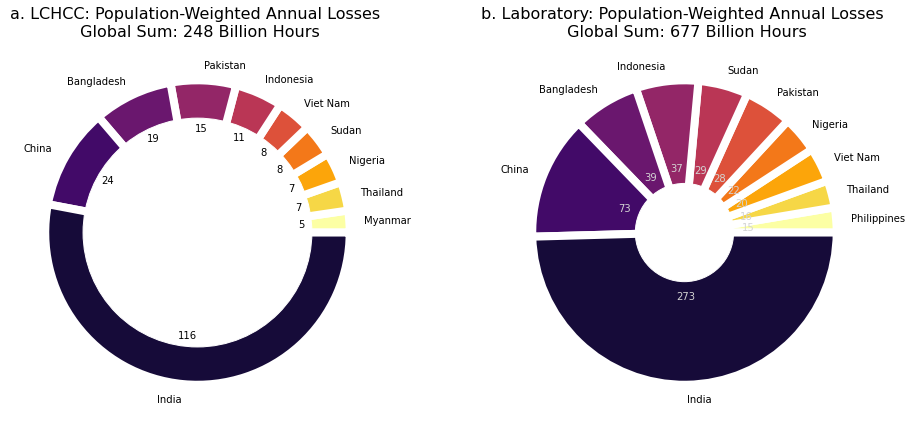

In [16]:
Subplot_Titles = ['LCHCC','Laboratory']

#Pick global warming factor

gwf = 0


# donut plot of top 10 countries with 12-hour workday labor lost
timeofday = ['12-Hour Workday']
MaxAmount = 1.0e3
colors_donuts = plt.cm.inferno_r(np.linspace(0,1,1+10))

fig = plt.figure(figsize=(16,7))

for ei,erf in enumerate(erfs):
    
    ax = plt.subplot(1,2,ei+1)

    country_sum_hourslost = np.zeros([len(countrynames_fraction)])
    for countryindex,country in countrynames_fraction.items():
        #print(countrynames_fraction[countryindex])
        country_sum_hourslost[countryindex] = (xr.ufuncs.ceil(countryfraction_nan[countryindex,:,:]) * vars()['laborlost_annual_LTM']['annual_hours_lost_'+str(erf)+'_12hrworkday_2001_2020_mean']).sum(dim=('lat','lon'))
    country_sum_hourslost_sortindex = np.argsort(country_sum_hourslost)
    countrynames_fraction_sortedbywagelost = countrynames_fraction[country_sum_hourslost_sortindex]

    names = countrynames_fraction_sortedbywagelost[len(countrynames_fraction_sortedbywagelost)-10:len(countrynames_fraction_sortedbywagelost)+1]
    size = country_sum_hourslost[country_sum_hourslost_sortindex][len(countrynames_fraction_sortedbywagelost)-10:len(countrynames_fraction_sortedbywagelost)+1]/1e9
    def autopct_format(size):
        def my_format(pct):
            total = sum(size)
            val = int(round(pct*total/100.0))
            return '{v:d}'.format(v=val)
        return my_format
    #explode = (0.2, 0.2, 0.2, 0.1, 0.1, 0, 0, 0, 0, 0)
    # Create a circle at the center of the plot
    TopCountrySum = np.nansum(country_sum_hourslost[country_sum_hourslost_sortindex][len(countrynames_fraction_sortedbywagelost)-10:len(countrynames_fraction_sortedbywagelost)+1]/1e9)
    AllCountrySum = (vars()['laborlost_annual_LTM']['annual_hours_lost_'+str(erf)+'_12hrworkday_2001_2020_mean'].sum(dim=('lat','lon'))/1e9).values #all countries
    radiussize = 1-(AllCountrySum/MaxAmount)
    my_circle = plt.Circle( (0,0), radiussize, color='white')
    if radiussize < 0.5:
        _, _, autotexts = plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize+0.1, colors=colors_donuts,wedgeprops = { 'linewidth' : 8, 'edgecolor' : 'white' })
        for autotext in autotexts:
            autotext.set_color('lightgrey')
#        plt.text(-.62, -1.36, 'Global: '+str(int(np.round(AllCountrySum,0)))+ ' Billion Hours',fontsize=16,color='black')
    else:
        plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize-0.07, colors=colors_donuts,wedgeprops = { 'linewidth' : 8, 'edgecolor' : 'white' })
#        plt.text(-.62, -1.36, 'Global: '+str(int(np.round(AllCountrySum,0)))+ ' Billion Hours',fontsize=16,color='black')

    p = plt.gcf()

    p.gca().add_artist(my_circle)

    if ei == 0:
            plt.title('a. '+str(Subplot_Titles[ei])+': Population-Weighted Annual Losses \n Global Sum: '+str(int(np.round(AllCountrySum,0)))+ ' Billion Hours',fontsize=16)
    if ei == 1:
            plt.title('b. '+str(Subplot_Titles[ei])+': Population-Weighted Annual Losses \n Global Sum: '+str(int(np.round(AllCountrySum,0)))+ ' Billion Hours',fontsize=16)  
           
    
#fig.savefig(FIGUREPATH + 'Figure_1_a_b_PopWeightedLosses_HeavyLabor_top10countries',dpi=300,bbox_inches='tight')


## Figure 1c, Figure 1d: DONUT PLOTS Per capita hours lost

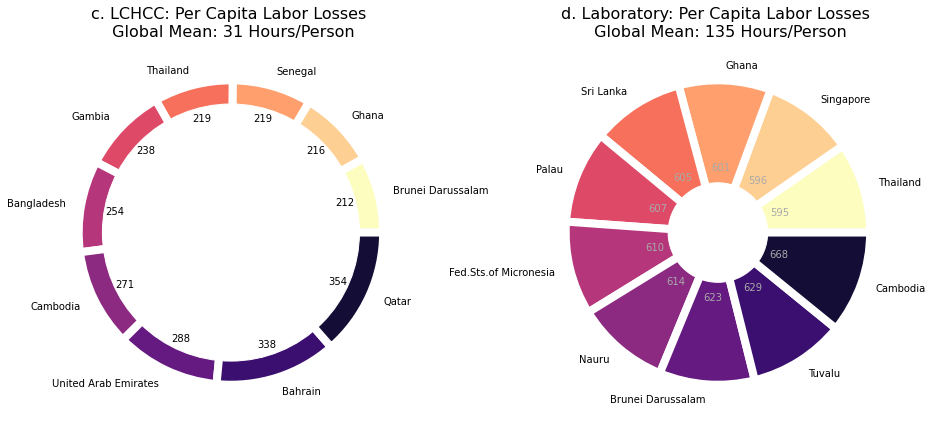

In [17]:
Subplot_Titles = ['LCHCC','Laboratory']

gwf = 0

# donut plot of top 10 countries with 12-hour workday labor lost per capita
timeofday = ['12-Hour Workday']
MaxAmount = 200
colors_donuts = plt.cm.magma_r(np.linspace(0,1,1+10))

fig = plt.figure(figsize=(16,7))

for ei,erf in enumerate(erfs):
    
    ax = plt.subplot(1,2,ei+1)

    laborlost_regridded_countrymaskgrid = vars()['hourslost_annual_LTM']['annual_hours_lost_'+str(erf)+'_12hrworkday_2001_2020']
    #regrid to country grid scale
    regridder = xe.Regridder(laborlost_regridded_countrymaskgrid, countryfraction, 'bilinear')#,reuse_weights=True) #'conservative' or 'bilinear'
    laborlost_regridded_countrymaskgrid = regridder(laborlost_regridded_countrymaskgrid)#regrid!

    country_mean_laborlost = np.zeros([len(countrynames_fraction)])
    for countryindex,country in countrynames_fraction.items():
        #print(countrynames_fraction[countryindex])
        country_mean_laborlost[countryindex] = np.nanmean(np.reshape(laborlost_regridded_countrymaskgrid.where(countryfraction[countryindex,:,:]>0).values,[len(LAT_countries)*len(LON_countries),1]))
    country_mean_laborlost_sortindex = np.argsort(country_mean_laborlost)
    countrynames_fraction_sortedbylaborlost = countrynames_fraction[country_mean_laborlost_sortindex]

    names = countrynames_fraction_sortedbylaborlost[len(countrynames_fraction_sortedbylaborlost)-10:len(countrynames_fraction_sortedbylaborlost)+1]
    size = country_mean_laborlost[country_mean_laborlost_sortindex][len(countrynames_fraction_sortedbylaborlost)-10:len(countrynames_fraction_sortedbylaborlost)+1]
    def autopct_format(size):
        def my_format(pct):
            total = sum(size)
            val = int(round(pct*total/100.0))
            return '{v:d}'.format(v=val)
        return my_format
    #explode = (0.2, 0.2, 0.2, 0.1, 0.1, 0, 0, 0, 0, 0)
    # Create a circle at the center of the plot
    TopCountrySum = np.nansum(country_mean_laborlost[country_mean_laborlost_sortindex][len(countrynames_fraction_sortedbylaborlost)-10:len(countrynames_fraction_sortedbylaborlost)+1])
    AllCountrySum = np.nanmean(np.reshape(laborlost_regridded_countrymaskgrid.values,[len(LAT_countries)*len(LON_countries),1]))
    radiussize = 1-(AllCountrySum/MaxAmount)
    my_circle = plt.Circle( (0,0), radiussize, color='white')
    if radiussize < 0.5:
        _, _, autotexts = plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize+0.1, colors=colors_donuts,wedgeprops = { 'linewidth' : 8, 'edgecolor' : 'white' })
        for autotext in autotexts:
            autotext.set_color('darkgrey')
    else:
        plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize-0.07, colors=colors_donuts,wedgeprops = { 'linewidth' : 8, 'edgecolor' : 'white' })

    p = plt.gcf()

    p.gca().add_artist(my_circle)
    
    if ei == 0:
            plt.title('c. '+str(Subplot_Titles[ei])+': Per Capita Labor Losses \n Global Mean: '+str(int(np.round(AllCountrySum,0)))+ ' Hours/Person',fontsize=16)
    if ei == 1:
            plt.title('d. '+str(Subplot_Titles[ei])+': Per Capita Labor Losses \n Global Mean: '+str(int(np.round(AllCountrySum,0)))+ ' Hours/Person',fontsize=16)  
            
fig.savefig(FIGUREPATH + 'Figure_1_c_d_PerCapitaLosses_HeavyLabor_top10countries',dpi=300,bbox_inches='tight')


## Donut plot: equivalent job losses (pop weighted labor losses/365*12)

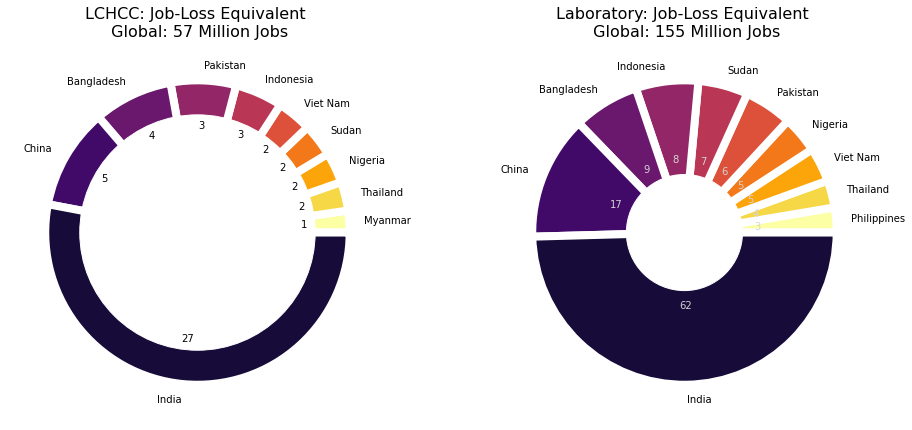

In [18]:
Subplot_Titles = ['LCHCC','Laboratory']

#Pick global warming factor

gwf = 0


# donut plot of top 10 countries with 12-hour workday labor lost
timeofday = ['12-Hour Workday']
MaxAmount = 250
colors_donuts = plt.cm.inferno_r(np.linspace(0,1,1+10))

fig = plt.figure(figsize=(16,7))

for ei,erf in enumerate(erfs):
    
    ax = plt.subplot(1,2,ei+1)

    country_sum_jobslost = np.zeros([len(countrynames_fraction)])
    for countryindex,country in countrynames_fraction.items():
        #print(countrynames_fraction[countryindex])
        country_sum_jobslost[countryindex] = (xr.ufuncs.ceil(countryfraction_nan[countryindex,:,:]) * 
                                                         vars()['laborlost_annual_LTM']['annual_hours_lost_'+str(erf)+'_12hrworkday_2001_2020_mean']).sum(dim=('lat','lon')) / (365*12)
    country_sum_jobslost_sortindex = np.argsort(country_sum_jobslost)
    countrynames_fraction_sortedbywagelost = countrynames_fraction[country_sum_jobslost_sortindex]

    names = countrynames_fraction_sortedbywagelost[len(countrynames_fraction_sortedbywagelost)-10:len(countrynames_fraction_sortedbywagelost)+1]
    size = country_sum_jobslost[country_sum_jobslost_sortindex][len(countrynames_fraction_sortedbywagelost)-10:len(countrynames_fraction_sortedbywagelost)+1]/1e6
    def autopct_format(size):
        def my_format(pct):
            total = sum(size)
            val = int(round(pct*total/100.0))
            return '{v:d}'.format(v=val)
        return my_format
    #explode = (0.2, 0.2, 0.2, 0.1, 0.1, 0, 0, 0, 0, 0)
    # Create a circle at the center of the plot
    TopCountrySum = np.nansum(country_sum_jobslost[country_sum_jobslost_sortindex][len(countrynames_fraction_sortedbywagelost)-10:len(countrynames_fraction_sortedbywagelost)+1]/1e6)
    AllCountrySum = (vars()['laborlost_annual_LTM']['annual_hours_lost_'+str(erf)+'_12hrworkday_2001_2020_mean'].sum(dim=('lat','lon'))/1e6).values/ (365*12) #all countries
    radiussize = 1-(AllCountrySum/MaxAmount)
    my_circle = plt.Circle( (0,0), radiussize, color='white')
    if radiussize < 0.5:
        _, _, autotexts = plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize+0.1, colors=colors_donuts,wedgeprops = { 'linewidth' : 8, 'edgecolor' : 'white' })
        for autotext in autotexts:
            autotext.set_color('lightgrey')
#        plt.text(-.62, -1.36, 'Global: '+str(int(np.round(AllCountrySum,0)))+ ' Million Jobs',fontsize=16,color='black')
    else:
        plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize-0.07, colors=colors_donuts,wedgeprops = { 'linewidth' : 8, 'edgecolor' : 'white' })
#        plt.text(-.62, -1.36, 'Global: '+str(int(np.round(AllCountrySum,0)))+ ' Million Jobs',fontsize=16,color='black')

    p = plt.gcf()

    p.gca().add_artist(my_circle)
    if ei == 0:
            plt.title(str(Subplot_Titles[ei])+': Job-Loss Equivalent \n Global: '+str(int(np.round(AllCountrySum,0)))+ ' Million Jobs',fontsize=16)
    if ei == 1:
            plt.title(str(Subplot_Titles[ei])+': Job-Loss Equivalent \n Global: '+str(int(np.round(AllCountrySum,0)))+ ' Million Jobs',fontsize=16)  
            
#fig.savefig(FIGUREPATH + 'era5_'+str(local_var)+'_Kjellstrom2018_Foster_NOMaxMinCutoff_Comparison_Global_Jobs_Lost_DonutPlots_GWF_'+str(gwf),dpi=300,bbox_inches='tight')


## World Bank  Ag and Construction GDP contribution losses in 2017 PPP$

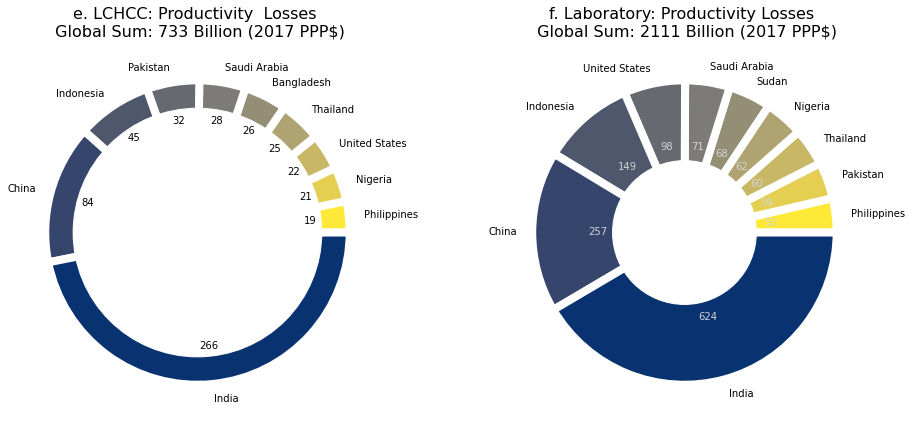

In [19]:
#### Now for World Bank ag and construction portion of GDP contribution to economy weighted GDP PPP Losses

Subplot_Titles = ['LCHCC','Laboratory']

timeperiod = 'earlier'

gwf = 0 #Pick global warming factor


# donut plot of top 10 countries with 12-hour workday wages lost
timeofday = ['12-Hour Workday']
MaxAmount = 4.0e3
colors_donuts = plt.cm.cividis_r(np.linspace(0,1,1+10))

fig = plt.figure(figsize=(16,7))

for ei, erf in enumerate(erfs):
    
    ax = plt.subplot(1,2,ei+1)
    GDPAgConstrPPP = vars()['prodlost_annual_LTM']['annualeconproductivity_lost_popweight_'+str(erf)+'_12hrworkday_2001_2020_mean']
    country_sum_wageslost = np.zeros([len(countrynames_fraction)])
    for countryindex,country in countrynames_fraction.items():
        #print(countrynames_fraction[countryindex])
        country_sum_wageslost[countryindex] = (xr.ufuncs.ceil(countryfraction_nan[countryindex,:,:]) * GDPAgConstrPPP).sum(dim=('lat','lon'))
    country_sum_wageslost_sortindex = np.argsort(country_sum_wageslost)
    countrynames_fraction_sortedbywagelost = countrynames_fraction[country_sum_wageslost_sortindex]

    names = countrynames_fraction_sortedbywagelost[len(countrynames_fraction_sortedbywagelost)-10:len(countrynames_fraction_sortedbywagelost)+1]
    size = country_sum_wageslost[country_sum_wageslost_sortindex][len(countrynames_fraction_sortedbywagelost)-10:len(countrynames_fraction_sortedbywagelost)+1]/1e9
    def autopct_format(size):
        def my_format(pct):
            total = sum(size)
            val = int(round(pct*total/100.0))
            return '{v:d}'.format(v=val)
        return my_format
    #explode = (0.2, 0.2, 0.2, 0.1, 0.1, 0, 0, 0, 0, 0)
    # Create a circle at the center of the plot
    TopCountrySum = np.nansum(country_sum_wageslost[country_sum_wageslost_sortindex][len(countrynames_fraction_sortedbywagelost)-10:len(countrynames_fraction_sortedbywagelost)+1]/1e9)
    AllCountrySum = (GDPAgConstrPPP.sum(dim=('lat','lon'))).values/1e9
    radiussize = 1-(AllCountrySum/MaxAmount)
    my_circle = plt.Circle( (0,0), radiussize, color='white')
    if radiussize < 0.5:
        _, _, autotexts = plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize+0.1, colors=colors_donuts,wedgeprops = { 'linewidth' : 8, 'edgecolor' : 'white' })
        for autotext in autotexts:
            autotext.set_color('lightgrey')
#        plt.text(-.7, -1.36, 'Global: '+str(int(np.round(AllCountrySum,0)))+ ' Billion US (PPP)',fontsize=16,color='black')
    else:
        plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize-0.07, colors=colors_donuts,wedgeprops = { 'linewidth' : 8, 'edgecolor' : 'white' })
#        plt.text(-.7, -1.36, 'Global: '+str(int(np.round(AllCountrySum,0)))+ ' Billion US (PPP)',fontsize=16,color='black')

    p = plt.gcf()

    p.gca().add_artist(my_circle)
    if ei == 0:
            plt.title('e. '+str(Subplot_Titles[ei])+': Productivity  Losses \n Global Sum: '+str(int(np.round(AllCountrySum,0)))+ ' Billion (2017 PPP$)',fontsize=16)
    if ei == 1:
            plt.title('f. '+str(Subplot_Titles[ei])+': Productivity Losses \n Global Sum: '+str(int(np.round(AllCountrySum,0)))+ ' Billion (2017 PPP$)',fontsize=16)  

fig.savefig(FIGUREPATH + 'Figure_1_e_f_Productivity2017PPP_Losses',dpi=300,bbox_inches='tight')


## per capita weeks of work lost

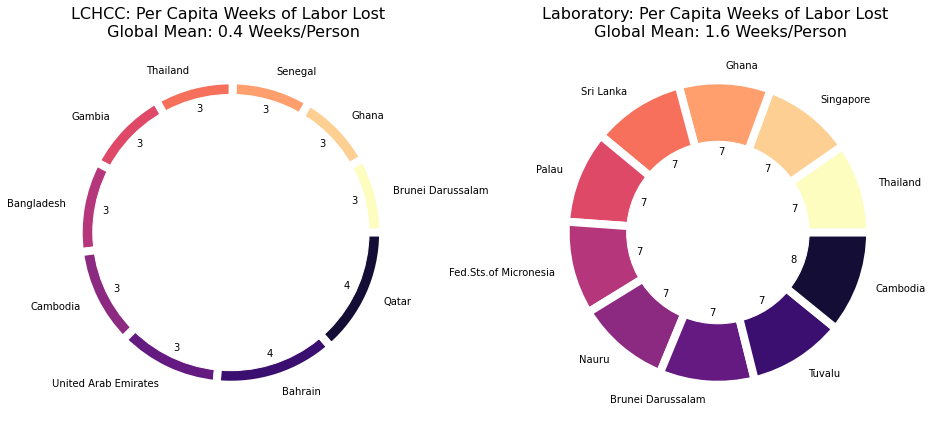

In [20]:
Subplot_Titles = ['LCHCC','Laboratory']

gwf = 0

# donut plot of top 10 countries with 12-hour workday labor lost per capita
timeofday = ['12-Hour Workday']
MaxAmount = 4
colors_donuts = plt.cm.magma_r(np.linspace(0,1,1+10))

fig = plt.figure(figsize=(16,7))

for ei,erf in enumerate(erfs):
    
    ax = plt.subplot(1,2,ei+1)

    laborlost_regridded_countrymaskgrid = vars()['hourslost_annual_LTM']['annual_hours_lost_'+str(erf)+'_12hrworkday_2001_2020']
    #regrid to country grid scale
    regridder = xe.Regridder(laborlost_regridded_countrymaskgrid, countryfraction, 'bilinear')#,reuse_weights=True) #'conservative' or 'bilinear'
    laborlost_regridded_countrymaskgrid = regridder(laborlost_regridded_countrymaskgrid)#regrid!
    laborlost_regridded_countrymaskgrid = laborlost_regridded_countrymaskgrid / (12*7) #convert to weeks of work lost equivalent!!

    country_mean_laborlost = np.zeros([len(countrynames_fraction)])
    for countryindex,country in countrynames_fraction.items():
        #print(countrynames_fraction[countryindex])
        country_mean_laborlost[countryindex] = np.nanmean(np.reshape(laborlost_regridded_countrymaskgrid.where(countryfraction[countryindex,:,:]>0).values,[len(LAT_countries)*len(LON_countries),1]))
    country_mean_laborlost_sortindex = np.argsort(country_mean_laborlost)
    countrynames_fraction_sortedbylaborlost = countrynames_fraction[country_mean_laborlost_sortindex]

    names = countrynames_fraction_sortedbylaborlost[len(countrynames_fraction_sortedbylaborlost)-10:len(countrynames_fraction_sortedbylaborlost)+1]
    size = country_mean_laborlost[country_mean_laborlost_sortindex][len(countrynames_fraction_sortedbylaborlost)-10:len(countrynames_fraction_sortedbylaborlost)+1]
    def autopct_format(size):
        def my_format(pct):
            total = sum(size)
            val = int(round(pct*total/100.0))
            return '{v:d}'.format(v=val)
        return my_format
    #explode = (0.2, 0.2, 0.2, 0.1, 0.1, 0, 0, 0, 0, 0)
    # Create a circle at the center of the plot
    TopCountrySum = np.nansum(country_mean_laborlost[country_mean_laborlost_sortindex][len(countrynames_fraction_sortedbylaborlost)-10:len(countrynames_fraction_sortedbylaborlost)+1])
    AllCountrySum = np.nanmean(np.reshape(laborlost_regridded_countrymaskgrid.values,[len(LAT_countries)*len(LON_countries),1]))
    radiussize = 1-(AllCountrySum/MaxAmount)
    my_circle = plt.Circle( (0,0), radiussize, color='white')
    if radiussize < 0.5:
        _, _, autotexts = plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize+0.1, colors=colors_donuts,wedgeprops = { 'linewidth' : 8, 'edgecolor' : 'white' })
        for autotext in autotexts:
            autotext.set_color('lightgrey')
#        plt.text(-.62, -1.36, 'Global: '+str((np.round(AllCountrySum,1)))+ ' Weeks/Person',fontsize=16,color='black')
    else:
        plt.pie(size, labels=names, autopct = autopct_format(size), pctdistance=radiussize-0.07, colors=colors_donuts,wedgeprops = { 'linewidth' : 8, 'edgecolor' : 'white' })
#        plt.text(-.62, -1.36, 'Global: '+str((np.round(AllCountrySum,1)))+ ' Weeks/Person',fontsize=16,color='black')

    p = plt.gcf()

    p.gca().add_artist(my_circle)

    if ei == 0:
            plt.title(str(Subplot_Titles[ei])+': Per Capita Weeks of Labor Lost \n Global Mean: '+str((np.round(AllCountrySum,1)))+ ' Weeks/Person',fontsize=16)
    if ei == 1:
            plt.title(str(Subplot_Titles[ei])+': Per Capita Weeks of Labor Lost \n Global Mean: '+str((np.round(AllCountrySum,1)))+ ' Weeks/Person',fontsize=16)  
           
    
#fig.savefig(FIGUREPATH + 'Figure_S',dpi=300,bbox_inches='tight')
